In [39]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2

import timm
import torch
import os
import tabulate
from IPython.display import display_markdown

device = 'cpu' # torch.device('cuda' if torch.cuda.is_available() else 'cpu')
basepath = os.path.abspath('../figures/shared-value-vectors')
os.makedirs(basepath, exist_ok=True)

model_names = ['vit_base_patch16_224', 
               'vit_base_patch16_224_miil', 
               'vit_base_patch32_224', 
               'vit_large_patch16_224']
pretty_model_names = {
    'vit_base_patch16_224': 'ViT-B/16', 
    'vit_base_patch16_224_miil': 'ViT-B/16-MIIL', 
    'vit_base_patch32_224': 'ViT-B/32', 
    'vit_large_patch16_224': 'ViT-L/16',
    'imagenet_val': 'ImageNet1k-Val'
}
models = {
    model_name: timm.create_model(model_name, pretrained=True).eval().to(device)
    for model_name in model_names
}


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### MLP

In [40]:
from src.utils.extraction import extract_value_vectors
from src.utils.model import embedding_projection
from src.analyzers.vector_analyzer import k_most_predictive_ind_for_classes
from src.analyzers.vector_analyzer import shared_value_vectors

k = 1

projected_values = {
    model_name: embedding_projection(models[model_name], 
                                     extract_value_vectors(models[model_name], device), device)
    for model_name in model_names
}
k_most_pred_inds = {
    model_name: k_most_predictive_ind_for_classes(projected_values[model_name], k, device)
    for model_name in model_names
}
shared_vectors = {
    model_name: shared_value_vectors(k_most_pred_inds[model_name], True)
    for model_name in model_names
}

#### Counts of Most Predictive MLP Value Vectors Shared by Two or More Classes  

In [41]:
for model_name, shared in shared_vectors.items():
    count = len(list(filter(lambda x: len(x[1]) > 1, [tuple(item) for item in shared.items()])))
    print(model_name, count)

vit_base_patch16_224 141
vit_base_patch16_224_miil 126
vit_base_patch32_224 148
vit_large_patch16_224 31


#### Counts of Most Predictive MLP Value Vectors Shared by Three or More Classes  

In [42]:
for model_name, shared in shared_vectors.items():
    count = len(list(filter(lambda x: len(x[1]) > 2, [tuple(item) for item in shared.items()])))
    print(model_name, count)

vit_base_patch16_224 35
vit_base_patch16_224_miil 66
vit_base_patch32_224 47
vit_large_patch16_224 3


#### Table of Top 4 Shared Most Predictive MLP Value Vectors

In [52]:
from IPython.display import display_markdown 

include_top = 4

rows = []
for model_name, shared in shared_vectors.items():
    shared = sorted([tuple(item) for item in shared.items()], key=lambda x: len(x[1]), reverse=True)
    for i in range(include_top):
        rows.append((pretty_model_names[model_name], i+1, shared[i][0][0]+1, len(list(map(lambda x: x[0], shared[i][1]))), 
                     ', '.join(map(lambda x: x[0], shared[i][1]))))
        
tbl_headers = ['Model', 'Top', 'Block', '$\\vert\\textbf{Classes}\\vert$', 'Classes']
display_markdown(tabulate.tabulate(rows, tbl_headers, floatfmt='.3f', tablefmt='github'), raw=True)

| Model         |   Top |   Block |   $\vert\textbf{Classes}\vert$ | Classes                                                                                                                                                                                                                                                                                                                                                                                         |
|---------------|-------|---------|--------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| ViT-B/16      |     1 |      12 |                             20 | daisy, lacewing, sea_anemone, cardoon, tiger_beetle, coral_fungus, lycaenid, vine_snake, hip, cabbage_butterfly, tree_frog, green_lizard, American_chameleon, harvestman, gyromitra, monarch, pot, bee, sulphur_butterfly, leaf_beetle                                                                                                                                                          |
| ViT-B/16      |     2 |      12 |                             19 | green_snake, mongoose, sea_cucumber, hermit_crab, macaque, guenon, mink, hen-of-the-woods, hornbill, ground_beetle, crayfish, porcupine, alligator_lizard, water_snake, Arctic_fox, earthstar, echidna, wood_rabbit, dung_beetle                                                                                                                                                                |
| ViT-B/16      |     3 |      12 |                             13 | potter's_wheel, Christmas_stocking, plunger, carton, crossword_puzzle, shower_cap, paper_towel, tobacco_shop, bolo_tie, shoe_shop, toyshop, nipple, jersey                                                                                                                                                                                                                                      |
| ViT-B/16      |     4 |      12 |                             10 | French_bulldog, Brabancon_griffon, Boston_bull, redbone, diaper, affenpinscher, Scotch_terrier, Norfolk_terrier, briard, Italian_greyhound                                                                                                                                                                                                                                                      |
| ViT-B/16-MIIL |     1 |      12 |                             29 | Tibetan_terrier, Norwegian_elkhound, golden_retriever, kelpie, English_springer, English_setter, Great_Pyrenees, boxer, clumber, Irish_setter, Border_collie, Shih-Tzu, cocker_spaniel, Shetland_sheepdog, Labrador_retriever, Sussex_spaniel, Brittany_spaniel, Pekinese, Norwich_terrier, pug, toy_poodle, Pomeranian, Saluki, Chihuahua, beagle, collie, German_shepherd, Maltese_dog, Lhasa |
| ViT-B/16-MIIL |     2 |      12 |                             10 | ambulance, trailer_truck, minibus, pickup, recreational_vehicle, jeep, trolleybus, police_van, tow_truck, fire_engine                                                                                                                                                                                                                                                                           |
| ViT-B/16-MIIL |     3 |      12 |                             10 | pirate, schooner, lifeboat, yawl, catamaran, speedboat, dock, trimaran, fireboat, liner                                                                                                                                                                                                                                                                                                         |
| ViT-B/16-MIIL |     4 |      12 |                              9 | car_wheel, beach_wagon, limousine, grille, racer, sports_car, minivan, cab, convertible                                                                                                                                                                                                                                                                                                         |
| ViT-B/32      |     1 |      10 |                             22 | Norwegian_elkhound, malinois, Scotch_terrier, kelpie, bull_mastiff, groenendael, chow, Labrador_retriever, Rottweiler, bluetick, cairn, giant_schnauzer, Siberian_husky, pug, soft-coated_wheaten_terrier, briard, kuvasz, white_wolf, malamute, Newfoundland, wild_boar, Border_terrier                                                                                                        |
| ViT-B/32      |     2 |      11 |                             18 | ptarmigan, jay, magpie, quail, coucal, ruffed_grouse, house_finch, bittern, brambling, oystercatcher, indigo_bunting, hornbill, bulbul, partridge, bee_eater, bustard, little_blue_heron, black_grouse                                                                                                                                                                                          |
| ViT-B/32      |     3 |      10 |                             17 | consomme, trifle, mixing_bowl, wok, eggnog, soup_bowl, dough, frying_pan, bagel, burrito, wooden_spoon, mashed_potato, meat_loaf, guacamole, carbonara, hot_pot, plate                                                                                                                                                                                                                          |
| ViT-B/32      |     4 |      10 |                             13 | Afghan_hound, Tibetan_mastiff, flat-coated_retriever, Leonberg, golden_retriever, Boston_bull, Brittany_spaniel, Border_collie, Saint_Bernard, Old_English_sheepdog, curly-coated_retriever, Irish_water_spaniel, Gordon_setter                                                                                                                                                                 |
| ViT-L/16      |     1 |      24 |                              4 | grocery_store, guacamole, cucumber, pretzel                                                                                                                                                                                                                                                                                                                                                     |
| ViT-L/16      |     2 |      24 |                              3 | green_lizard, American_chameleon, coral_fungus                                                                                                                                                                                                                                                                                                                                                  |
| ViT-L/16      |     3 |      24 |                              3 | sulphur_butterfly, bee, hen-of-the-woods                                                                                                                                                                                                                                                                                                                                                        |
| ViT-L/16      |     4 |      22 |                              2 | vine_snake, green_snake                                                                                                                                                                                                                                                                                                                                                                         |

## Attn

In [53]:
from src.utils.extraction import extract_mhsa_proj_vectors

projected_values_attn = {
    model_name: embedding_projection(models[model_name], 
                                     extract_mhsa_proj_vectors(models[model_name], device), device)
    for model_name in model_names
}
k_most_pred_inds_attn = {
    model_name: k_most_predictive_ind_for_classes(projected_values_attn[model_name], k, device)
    for model_name in model_names
}
shared_vectors_attn = {
    model_name: shared_value_vectors(k_most_pred_inds_attn[model_name], True)
    for model_name in model_names
}

#### Counts of Most Predictive Attention Value Vectors Shared by Two or More Classes  

In [54]:
for model_name, shared in shared_vectors_attn.items():
    count = len(list(filter(lambda x: len(x[1]) > 1, [tuple(item) for item in shared.items()])))
    total = sum(list(map(lambda x: len(x[1]), 
                         filter(lambda x: len(x[1]) > 1, [tuple(item) for item in shared.items()]))))
    print(model_name, count, total)

vit_base_patch16_224 93 906
vit_base_patch16_224_miil 125 331
vit_base_patch32_224 155 871
vit_large_patch16_224 93 915


#### Counts of Most Predictive Attention Value Vectors Shared by Three or More Classes  

In [55]:
for model_name, shared in shared_vectors_attn.items():
    count = len(list(filter(lambda x: len(x[1]) > 2, [tuple(item) for item in shared.items()])))
    total = sum(list(map(lambda x: len(x[1]), 
                         filter(lambda x: len(x[1]) > 2, [tuple(item) for item in shared.items()]))))
    print(model_name, count, total)

vit_base_patch16_224 72 864
vit_base_patch16_224_miil 41 163
vit_base_patch32_224 104 769
vit_large_patch16_224 68 865


#### Table of Top 4 Shared Most Predictive Attention Value Vectors

In [56]:
include_top = 4

rows = []
for model_name, shared in shared_vectors_attn.items():
    shared = sorted([tuple(item) for item in shared.items()], key=lambda x: len(x[1]), reverse=True)
    for i in range(include_top):
        rows.append((pretty_model_names[model_name], i+1, shared[i][0][0]+1, 
                     len(list(map(lambda x: x[0], shared[i][1]))), 
                     ', '.join(map(lambda x: x[0], shared[i][1]))))
        
tbl_headers = ['Model', 'Top', 'Block', '$\\vert\\textbf{Classes}\\vert$', 'Classes']
display_markdown(tabulate.tabulate(rows, tbl_headers, floatfmt='.3f', tablefmt='github'), raw=True)

| Model         |   Top |   Block |   $\vert\textbf{Classes}\vert$ | Classes                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        |
|---------------|-------|---------|--------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| ViT-B/16      |     1 |      12 |                             63 | iPod, dumbbell, microphone, gas_pump, slot, radiator, grille, toaster, vacuum, photocopier, cassette, computer_keyboard, projector, dishwasher, power_drill, oscilloscope, parking_meter, barber_chair, television, joystick, CD_player, hard_disc, space_bar, space_heater, cash_machine, tape_player, desktop_computer, cellular_telephone, home_theater, scale, remote_control, screen, mailbox, file, pay-phone, sewing_machine, safe, monitor, hand-held_computer, reflex_camera, iron, radio, grand_piano, notebook, laptop, desk, printer, digital_clock, dial_telephone, rotisserie, stove, typewriter_keyboard, upright, mouse, washer, hand_blower, Polaroid_camera, stethoscope, cassette_player, harmonica, microwave, loudspeaker, carpenter's_kit                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                |
| ViT-B/16      |     2 |      12 |                             57 | Leonberg, limousine, trombone, minibus, unicycle, sax, horizontal_bar, go-kart, gasmask, balance_beam, sunglass, toyshop, lab_coat, cello, cinema, banjo, plunger, barbershop, harp, stretcher, oxygen_mask, bearskin, bassoon, violin, volleyball, military_uniform, cornet, mountain_bike, torch, flute, football_helmet, jinrikisha, bow, golfcart, assault_rifle, police_van, rugby_ball, crash_helmet, bullet_train, basketball, crutch, ambulance, French_horn, cowboy_hat, library, marimba, parallel_bars, soccer_ball, bicycle-built-for-two, ballplayer, steel_drum, bobsled, stage, oboe, neck_brace, mortarboard, accordion                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        |
| ViT-B/16      |     3 |      12 |                             55 | vending_machine, whiskey_jug, pretzel, carton, jigsaw_puzzle, lotion, crossword_puzzle, beer_glass, milk_can, refrigerator, water_bottle, ashcan, nipple, red_wine, ice_cream, cup, tray, teapot, espresso, packet, book_jacket, soap_dispenser, pill_bottle, restaurant, pop_bottle, dough, paper_towel, sunscreen, cocktail_shaker, ice_lolly, eggnog, cheeseburger, confectionery, medicine_chest, pitcher, saltshaker, goblet, coffeepot, beer_bottle, perfume, trifle, candle, measuring_cup, water_jug, beaker, wine_bottle, bottlecap, piggy_bank, chocolate_sauce, toilet_tissue, bakery, menu, coffee_mug, Crock_Pot, vase                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            |
| ViT-B/16      |     4 |      12 |                             45 | maypole, beach_wagon, mountain_tent, pirate, container_ship, wing, comic_book, missile, space_shuttle, moving_van, trimaran, radio_telescope, street_sign, flagpole, convertible, amphibian, airliner, carousel, tobacco_shop, turnstile, umbrella, planetarium, balloon, pier, schooner, lifeboat, catamaran, dock, breakwater, cab, projectile, liner, water_tower, sandbar, gondola, sports_car, airship, minivan, drilling_platform, solar_dish, speedboat, traffic_light, paddlewheel, fireboat, parachute                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                |
| ViT-B/16-MIIL |     1 |      11 |                             19 | king_penguin, Sealyham_terrier, crane, dalmatian, Eskimo_dog, oystercatcher, American_egret, ice_bear, black_stork, sulphur-crested_cockatoo, Samoyed, West_Highland_white_terrier, spoonbill, white_stork, pelican, kuvasz, African_grey, albatross, miniature_poodle                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         |
| ViT-B/16-MIIL |     2 |      11 |                              6 | bison, cougar, llama, sorrel, African_hunting_dog, goose                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       |
| ViT-B/16-MIIL |     3 |      11 |                              6 | standard_poodle, Bedlington_terrier, lesser_panda, Scottish_deerhound, toy_poodle, guenon                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      |
| ViT-B/16-MIIL |     4 |      12 |                              6 | French_bulldog, Boston_bull, Cardigan, Mexican_hairless, kelpie, miniature_pinscher                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            |
| ViT-B/32      |     1 |      12 |                             86 | Brabancon_griffon, meerkat, baboon, kelpie, Rhodesian_ridgeback, spider_monkey, bull_mastiff, Irish_setter, Greater_Swiss_Mountain_dog, ram, siamang, chimpanzee, horse_cart, borzoi, cocker_spaniel, Australian_terrier, warthog, water_buffalo, Afghan_hound, dhole, Saint_Bernard, German_short-haired_pointer, Rottweiler, langur, kuvasz, redbone, whippet, tiger, EntleBucher, flat-coated_retriever, lion, Weimaraner, Ibizan_hound, Staffordshire_bullterrier, basset, brown_bear, Eskimo_dog, giant_panda, African_elephant, koala, miniature_schnauzer, Chesapeake_Bay_retriever, cheetah, kit_fox, American_Staffordshire_terrier, gibbon, malinois, English_setter, Old_English_sheepdog, orangutan, sloth_bear, jaguar, Doberman, Mexican_hairless, Irish_wolfhound, papillon, Chihuahua, beagle, collie, Arabian_camel, ostrich, bison, cougar, Leonberg, llama, timber_wolf, oxcart, Gordon_setter, Tibetan_mastiff, groenendael, boxer, Border_collie, zebra, Indian_elephant, Shetland_sheepdog, Labrador_retriever, hippopotamus, Bernese_mountain_dog, ibex, wombat, Saluki, German_shepherd, ox, Newfoundland, Irish_water_spaniel, gorilla                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                |
| ViT-B/32      |     2 |      12 |                             29 | iPod, microphone, fountain_pen, oil_filter, screwdriver, knot, lens_cap, lighter, corkscrew, mousetrap, modem, pill_bottle, chain, syringe, nail, ballpoint, drumstick, pencil_sharpener, rubber_eraser, spindle, hammer, measuring_cup, ladle, thimble, matchstick, hand_blower, stethoscope, combination_lock, harmonica                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     |
| ViT-B/32      |     3 |      12 |                             27 | red-backed_sandpiper, bittern, sidewinder, partridge, mud_turtle, prairie_chicken, damselfly, cabbage_butterfly, hognose_snake, American_coot, limpkin, redshank, sea_snake, whiptail, box_turtle, garter_snake, dowitcher, African_crocodile, fiddler_crab, alligator_lizard, water_snake, sulphur_butterfly, ruffed_grouse, European_gallinule, rock_python, little_blue_heron, water_ouzel                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |
| ViT-B/32      |     4 |      12 |                             23 | gas_pump, limousine, minibus, grille, photocopier, projector, convertible, fire_engine, cinema, recreational_vehicle, cash_machine, desktop_computer, home_theater, passenger_car, golfcart, police_van, cab, bullet_train, ambulance, washer, racer, sports_car, minivan                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      |
| ViT-L/16      |     1 |      24 |                            113 | English_foxhound, Blenheim_spaniel, hyena, kelpie, Rhodesian_ridgeback, dalmatian, Great_Pyrenees, bull_mastiff, Irish_setter, Greater_Swiss_Mountain_dog, ram, chow, Airedale, borzoi, cocker_spaniel, Australian_terrier, warthog, water_buffalo, Afghan_hound, dhole, basenji, standard_poodle, Saint_Bernard, German_short-haired_pointer, Pekinese, Rottweiler, soft-coated_wheaten_terrier, standard_schnauzer, kuvasz, redbone, whippet, wire-haired_fox_terrier, malamute, Kerry_blue_terrier, keeshond, EntleBucher, Weimaraner, Ibizan_hound, basset, Staffordshire_bullterrier, English_springer, French_bulldog, Eskimo_dog, Boston_bull, African_elephant, Norfolk_terrier, miniature_schnauzer, Chesapeake_Bay_retriever, skunk, Scottish_deerhound, giant_schnauzer, Siberian_husky, curly-coated_retriever, Samoyed, schipperke, American_Staffordshire_terrier, Irish_terrier, Tibetan_terrier, Norwegian_elkhound, red_wolf, malinois, English_setter, Old_English_sheepdog, bloodhound, Welsh_springer_spaniel, komondor, dingo, Brittany_spaniel, Doberman, Mexican_hairless, bluetick, Irish_wolfhound, papillon, briard, Chihuahua, beagle, Bedlington_terrier, collie, wild_boar, Appenzeller, Arabian_camel, Lakeland_terrier, Walker_hound, Border_terrier, Leonberg, golden_retriever, llama, Scotch_terrier, hog, Gordon_setter, Tibetan_mastiff, groenendael, boxer, clumber, Border_collie, Shetland_sheepdog, Labrador_retriever, Great_Dane, Bernese_mountain_dog, Cardigan, Norwich_terrier, cairn, pug, West_Highland_white_terrier, Saluki, German_shepherd, white_wolf, ox, Lhasa, miniature_poodle, Pembroke, Irish_water_spaniel, gorilla |
| ViT-L/16      |     2 |      22 |                             66 | binoculars, dumbbell, microphone, gas_pump, reel, fountain_pen, trombone, letter_opener, screwdriver, vacuum, lighter, corkscrew, gasmask, power_drill, banjo, cleaver, plunger, shovel, whistle, padlock, guillotine, screw, bassoon, violin, chime, syringe, broom, cornet, ballpoint, drumstick, scabbard, pencil_sharpener, cellular_telephone, torch, swab, racket, acoustic_guitar, barbell, lipstick, remote_control, loupe, spatula, hammer, bow, chain_saw, electric_guitar, assault_rifle, reflex_camera, holster, rule, projectile, revolver, crutch, plane, tripod, disk_brake, hand_blower, stethoscope, combination_lock, paintbrush, oboe, harmonica, rifle, slide_rule, hatchet, carpenter's_kit                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               |
| ViT-L/16      |     3 |      23 |                             42 | red-backed_sandpiper, hummingbird, common_iguana, bittern, tiger_beetle, dragonfly, chickadee, partridge, agama, ptarmigan, quail, jacamar, house_finch, redshank, whiptail, green_lizard, American_chameleon, cricket, junco, magpie, garter_snake, lorikeet, fly, long-horned_beetle, ruddy_turnstone, brambling, African_chameleon, ringneck_snake, alligator_lizard, cicada, jay, bullfrog, ruffed_grouse, coucal, admiral, robin, indigo_bunting, bulbul, bee_eater, goldfinch, frilled_lizard, water_ouzel                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               |
| ViT-L/16      |     4 |      22 |                             40 | vending_machine, toaster, photocopier, cassette, computer_keyboard, projector, dishwasher, refrigerator, oscilloscope, modem, joystick, CD_player, hard_disc, odometer, space_bar, space_heater, cash_machine, tape_player, desktop_computer, scale, screen, binder, pay-phone, sewing_machine, safe, monitor, hand-held_computer, radio, notebook, laptop, printer, digital_clock, rotisserie, typewriter_keyboard, washer, Polaroid_camera, switch, cassette_player, microwave, loudspeaker                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |

### ViT-L/16 overlap with ImageNet-1k Dogs

In [57]:
from src.utils.imagenet import get_imagenet_id_for_names

stanford_dog_classes = [ "n02110627", "n02088094", "n02116738", "n02096051", "n02093428", "n02107908", "n02096294", "n02110806", "n02088238", "n02088364", "n02093647", "n02107683", "n02089078", "n02086646", "n02088466", "n02088632", "n02106166", "n02093754", "n02090622", "n02096585", "n02106382", "n02108089", "n02112706", "n02105251", "n02101388", "n02108422", "n02096177", "n02113186", "n02099849", "n02085620", "n02112137", "n02101556", "n02102318", "n02106030", "n02099429", "n02096437", "n02115913", "n02115641", "n02107142", "n02089973", "n02100735", "n02102040", "n02108000", "n02109961", "n02099267", "n02108915", "n02106662", "n02100236", "n02097130", "n02099601", "n02101006", "n02109047", "n02111500", "n02107574", "n02105056", "n02091244", "n02100877", "n02093991", "n02102973", "n02090721", "n02091032", "n02085782", "n02112350", "n02105412", "n02093859", "n02105505", "n02104029", "n02099712", "n02095570", "n02111129", "n02098413", "n02110063", "n02105162", "n02085936", "n02113978", "n02107312", "n02113712", "n02097047", "n02111277", "n02094114", "n02091467", "n02094258", "n02105641", "n02091635", "n02086910", "n02086079", "n02113023", "n02112018", "n02110958", "n02090379", "n02087394", "n02106550", "n02109525", "n02091831", "n02111889", "n02104365", "n02097298", "n02092002", "n02095889", "n02105855", "n02086240", "n02110185", "n02097658", "n02098105", "n02093256", "n02113799", "n02097209", "n02102480", "n02108551", "n02097474", "n02113624", "n02087046", "n02100583", "n02089867", "n02092339", "n02102177", "n02098286", "n02091134", "n02095314", "n02094433"]

shared = sorted([tuple(item) for item in shared_vectors_attn['vit_large_patch16_224'].items()], 
                key=lambda x: len(x[1]), reverse=True)
len(set(get_imagenet_id_for_names(list(map(lambda x: x[0], shared[0][1])))).intersection(set(stanford_dog_classes)))

98

### MLP Images

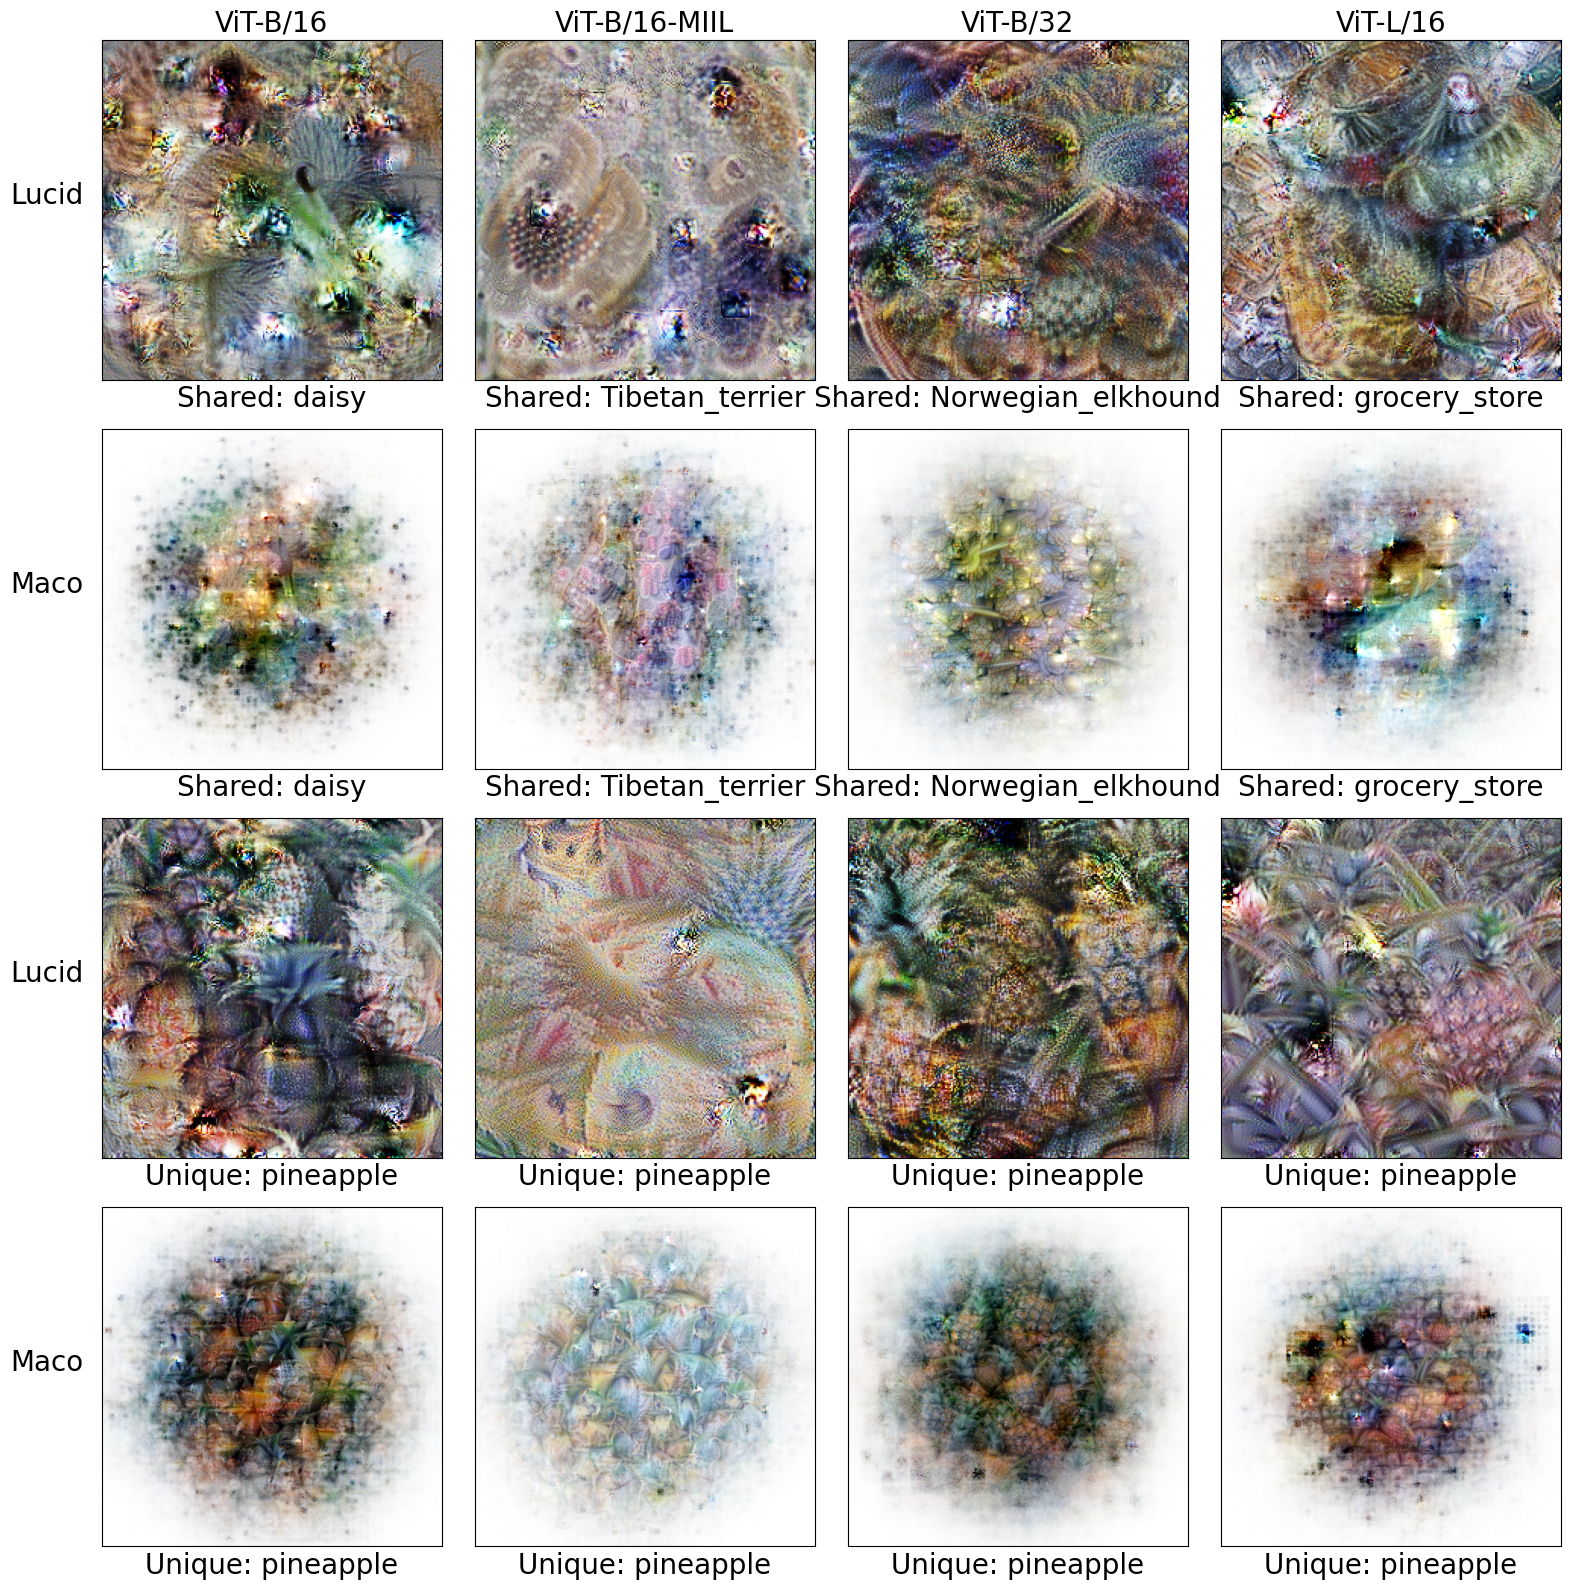

In [58]:
from matplotlib import pyplot as plt
from src.datasets.MixedPredictiveImagesMaco import MixedPredictiveImagesMacoDataset
from src.datasets.MixedPredictiveImages import MixedPredictiveImagesDataset
from src.utils.imagenet import get_imagenet_id_for_name

fig, axes = plt.subplots(4, 4, figsize=(16, 16))

for i, (model_name, shared) in enumerate(shared_vectors.items()):
    ds_lucid = MixedPredictiveImagesDataset(
        'A:\\CVData\\project-images\\images-mixed-224-fc1-multimodel',
        gen_types='clear', tops={'1'}, models={model_name})
    ds_maco = MixedPredictiveImagesMacoDataset(
        'A:\\CVData\\project-images\\images-mixed-1280-fc1-multimodel-maco',
        tops={'1'}, models={model_name}, rgba=True)
    
    shared = sorted([tuple(item) for item in shared.items()], key=lambda x: len(x[1]), reverse=True)
    name_shared = list(shared[0][1])[0][0]
    imagenet_id_shared = get_imagenet_id_for_name(name_shared)

    ds_lucid.lock_category(imagenet_id_shared)
    ds_maco.lock_category(imagenet_id_shared)

    col_ax = axes[:, i]

    if i == 0:
        col_ax[0].set_ylabel('Lucid', fontsize=20, rotation=0, labelpad=40)
        col_ax[1].set_ylabel('Maco', fontsize=20, rotation=0, labelpad=40)
        col_ax[2].set_ylabel('Lucid', fontsize=20, rotation=0, labelpad=40)
        col_ax[3].set_ylabel('Maco', fontsize=20, rotation=0, labelpad=40)

    col_ax[0].set_title(pretty_model_names[model_name], fontsize=20)
    [ax.set_xticks([]) for ax in col_ax]
    [ax.set_yticks([]) for ax in col_ax]

    col_ax[0].set_xlabel(f'Shared: {name_shared}', fontsize=20)
    col_ax[1].set_xlabel(f'Shared: {name_shared}', fontsize=20)
    col_ax[0].imshow(ds_lucid[0]['img'])
    col_ax[1].imshow(ds_maco[0]['img'])

    name_unique = 'pineapple' # list(shared[-1][1])[0][0]
    imagenet_id_unique = get_imagenet_id_for_name(name_unique)

    ds_lucid.lock_category(imagenet_id_unique)
    ds_maco.lock_category(imagenet_id_unique)

    col_ax[2].set_xlabel(f'Unique: {name_unique}', fontsize=20)
    col_ax[3].set_xlabel(f'Unique: {name_unique}', fontsize=20)
    col_ax[2].imshow(ds_lucid[0]['img'])
    col_ax[3].imshow(ds_maco[0]['img'])

fig.tight_layout()

plt.savefig(os.path.join(basepath, 'shared-vector-images.pdf'))

plt.show()

### Quantitative Image Evaluation

In [59]:
plausibility_lucid_path = "A:\\CVData\\project-images\\images-mixed-224-fc1-multimodel\\plausibility_with_gen.db"
transferability_lucid_path = "A:\\CVData\\project-images\\images-mixed-224-fc1-multimodel\\transferability_with_gen.db"
fid_top1_lucid_path = "A:\\CVData\\project-images\\images-mixed-224-fc1-multimodel\\fid_top1_clear_corrected.json"

plausibility_maco_path = "A:\\CVData\\project-images\\images-mixed-1280-fc1-multimodel-maco\\plausibility_with_gen.db"
transferability_maco_path = "A:\\CVData\\project-images\\images-mixed-1280-fc1-multimodel-maco\\transferability_with_gen.db"
fid_top_1_maco_path = "A:\\CVData\\project-images\\images-mixed-1280-fc1-multimodel-maco\\fid_top1_corrected.json"

In [103]:
import json
from src.utils.imagenet import get_all_classes, get_imagenet_id_for_name
import db_utils as dbu

fid_lucid = None
fid_maco = None

unshared_categories = {
    model_name: set(map(lambda x: get_imagenet_id_for_name(x[0]), 
                        set().union(*list(filter(lambda x: len(x)==1, shared.values())))))
    for model_name, shared in shared_vectors.items()
}
shared_categories = {
    model_name: set(get_all_classes()) - unshared_categories[model_name]
    for model_name in model_names
}

transferability_models = dbu.get_transferability_models(True)

def get_fid_for_cats(fid_by_cat, cats):
    return {
        model_name: (sum([fid_by_cat[category] for category in cats[model_name]]) / 
                        len(cats[model_name]))
        for model_name in model_names
    }

def get_transferability_for_cats(transferability_by_model_pred_cat, cats):
    return {
        model_name: {
            trans_model: (sum([transferability_by_model_pred_cat[model_name][trans_model][category]
                            for category in cats[model_name]]) /
                            len(cats[model_name]))
            for trans_model in transferability_models
        }
        for model_name in model_names
    }

def get_plausibility_for_cats(plausbility_by_model, cats):
    return {
        model_name: (sum([plausbility_by_model[model_name][category] 
                            for category in cats[model_name]]) / len(cats[model_name]))
        for model_name in model_names
    }

with open(fid_top1_lucid_path) as f:
    fid_lucid = json.load(f)
with open(fid_top_1_maco_path) as f:
    fid_maco = json.load(f)

fid_lucid_shared = get_fid_for_cats(fid_lucid, shared_categories)
fid_lucid_unshared = get_fid_for_cats(fid_lucid, unshared_categories)

fid_maco_shared = get_fid_for_cats(fid_maco, shared_categories)
fid_maco_unshared = get_fid_for_cats(fid_maco, unshared_categories)

lucid_transferability_by_model_and_cat = dbu.transferability_score(
    transferability_lucid_path, True, ['gen_model', 'pred_model', 'imagenet_id'])
maco_transferability_by_model_and_cat = dbu.transferability_score(
    transferability_maco_path, True, ['gen_model', 'pred_model', 'imagenet_id']
)

transferability_lucid_shared = get_transferability_for_cats(
    lucid_transferability_by_model_and_cat, shared_categories
)
transferability_lucid_unshared = get_transferability_for_cats(
    lucid_transferability_by_model_and_cat, unshared_categories
)
transferability_maco_shared = get_transferability_for_cats(
    maco_transferability_by_model_and_cat, shared_categories
)
transferability_maco_unshared = get_transferability_for_cats(
    maco_transferability_by_model_and_cat, unshared_categories
)

lucid_plausibility_by_model = dbu.plausibility_score(plausibility_lucid_path, 
                                                    ['gen_model', 'imagenet_id'])
maco_plausibility_by_model = dbu.plausibility_score(plausibility_maco_path, 
                                                    ['gen_model', 'imagenet_id'])

plausbility_lucid_shared = get_plausibility_for_cats(lucid_plausibility_by_model, shared_categories)
plausbility_lucid_unshared = get_plausibility_for_cats(
    lucid_plausibility_by_model, unshared_categories)
plausbility_maco_shared = get_plausibility_for_cats(maco_plausibility_by_model, shared_categories)
plausbility_maco_unshared = get_plausibility_for_cats(
    maco_plausibility_by_model, unshared_categories)

#### Plausibility

In [109]:
tbl = tabulate.tabulate([
    ['Yes'] + [f'{plausbility_lucid_shared[model_name]:.2f} $\\vert$ '
                f'{plausbility_maco_shared[model_name]:.2f}' 
                  for model_name in model_names],
    ['No'] + [f'{plausbility_lucid_unshared[model_name]:.2f} $\\vert$ '
                 f'{plausbility_maco_unshared[model_name]:.2f}'
                 for model_name in model_names]
], ['Shared'] + [pretty_model_names[model_name] for model_name in model_names], 
floatfmt='.3f', tablefmt='github')

display_markdown(tbl, raw=True)

| Shared   | ViT-B/16                | ViT-B/16-MIIL         | ViT-B/32              | ViT-L/16                |
|----------|-------------------------|-----------------------|-----------------------|-------------------------|
| Yes      | 1083.89 $\vert$ 1079.56 | 481.03 $\vert$ 480.23 | 330.38 $\vert$ 331.94 | 1128.45 $\vert$ 1212.76 |
| No       | 1023.29 $\vert$ 1010.13 | 369.16 $\vert$ 353.81 | 320.00 $\vert$ 314.44 | 1058.11 $\vert$ 1170.77 |

#### Transferability

In [108]:
pretty_trans_models = dbu.get_transferability_models_pretty(True)

table_rows = []

for trans_name, trans_name_pretty in pretty_trans_models.items():
    shared_zipped = zip([(transferability_lucid_shared, transferability_maco_shared),
                         (transferability_lucid_unshared, transferability_maco_unshared)], 
                        ['Yes', 'No'])
    for (stats_lucid, stats_maco), is_shared in shared_zipped:
        table_rows.append([trans_name_pretty, is_shared] + [
            f'{stats_lucid[model_name][trans_name]*100:.2f} $\\vert$ '
            f'{stats_maco[model_name][trans_name]*100:.2f}'
            for model_name in model_names])

tbl = tabulate.tabulate(table_rows, 
                        ['Prediction Model', 'Shared'] + 
                        [pretty_model_names[model_name] for model_name in model_names],
                        floatfmt='.3f', tablefmt='github')

display_markdown(tbl, raw=True)

| Prediction Model   | Shared   | ViT-B/16            | ViT-B/16-MIIL       | ViT-B/32            | ViT-L/16            |
|--------------------|----------|---------------------|---------------------|---------------------|---------------------|
| MobileNet          | Yes      | 6.57 $\vert$ 16.50  | 5.10 $\vert$ 10.47  | 4.80 $\vert$ 21.50  | 2.42 $\vert$ 13.73  |
| MobileNet          | No       | 11.43 $\vert$ 27.78 | 19.80 $\vert$ 31.38 | 8.54 $\vert$ 48.08  | 6.11 $\vert$ 15.13  |
| VGG16              | Yes      | 1.44 $\vert$ 10.24  | 0.92 $\vert$ 9.40   | 0.57 $\vert$ 15.19  | 0.32 $\vert$ 11.27  |
| VGG16              | No       | 2.36 $\vert$ 19.36  | 3.20 $\vert$ 27.48  | 1.23 $\vert$ 28.32  | 1.45 $\vert$ 12.12  |
| Xception           | Yes      | 7.12 $\vert$ 21.74  | 4.76 $\vert$ 14.22  | 6.63 $\vert$ 23.05  | 3.36 $\vert$ 23.04  |
| Xception           | No       | 12.53 $\vert$ 36.80 | 16.75 $\vert$ 43.09 | 9.88 $\vert$ 49.77  | 7.85 $\vert$ 25.00  |
| EfficientNet       | Yes      | 4.65 $\vert$ 17.60  | 3.89 $\vert$ 9.79   | 4.86 $\vert$ 24.07  | 1.10 $\vert$ 14.71  |
| EfficientNet       | No       | 8.33 $\vert$ 31.13  | 14.13 $\vert$ 31.62 | 9.00 $\vert$ 50.00  | 4.15 $\vert$ 17.42  |
| Tiny ConvNext      | Yes      | 18.09 $\vert$ 36.55 | 12.30 $\vert$ 28.59 | 14.66 $\vert$ 35.05 | 14.92 $\vert$ 46.08 |
| Tiny ConvNext      | No       | 36.67 $\vert$ 73.98 | 41.98 $\vert$ 76.18 | 26.85 $\vert$ 75.35 | 24.08 $\vert$ 58.44 |
| DenseNet           | Yes      | 7.13 $\vert$ 18.19  | 6.22 $\vert$ 12.00  | 5.32 $\vert$ 22.43  | 4.25 $\vert$ 21.57  |
| DenseNet           | No       | 11.22 $\vert$ 29.15 | 21.08 $\vert$ 34.28 | 10.08 $\vert$ 45.80 | 7.38 $\vert$ 18.53  |
| ViT-B/16           | Yes      | 47.40 $\vert$ 45.09 | 12.56 $\vert$ 19.50 | 20.14 $\vert$ 36.53 | 33.77 $\vert$ 37.75 |
| ViT-B/16           | No       | 91.47 $\vert$ 91.20 | 43.13 $\vert$ 59.57 | 40.28 $\vert$ 79.95 | 57.11 $\vert$ 57.73 |
| ViT-B/16-MIIL      | Yes      | 27.34 $\vert$ 30.63 | 28.37 $\vert$ 31.73 | 18.07 $\vert$ 34.03 | 23.74 $\vert$ 25.49 |
| ViT-B/16-MIIL      | No       | 54.28 $\vert$ 60.67 | 77.98 $\vert$ 82.03 | 33.95 $\vert$ 75.70 | 38.48 $\vert$ 34.91 |
| ViT-B/32           | Yes      | 31.78 $\vert$ 20.90 | 11.80 $\vert$ 5.96  | 39.37 $\vert$ 38.47 | 24.32 $\vert$ 12.25 |
| ViT-B/32           | No       | 64.24 $\vert$ 42.24 | 42.48 $\vert$ 23.88 | 83.37 $\vert$ 83.62 | 42.75 $\vert$ 12.45 |
| ViT-L/16           | Yes      | 40.57 $\vert$ 38.07 | 18.19 $\vert$ 23.39 | 26.64 $\vert$ 36.60 | 64.08 $\vert$ 50.00 |
| ViT-L/16           | No       | 80.20 $\vert$ 79.59 | 58.85 $\vert$ 70.98 | 57.07 $\vert$ 79.55 | 94.45 $\vert$ 77.47 |

#### FID

In [113]:
tbl = tabulate.tabulate([
    ['Yes'] + [f'{fid_lucid_shared[model_name]:.2f} $\\vert$ '
                f'{fid_maco_shared[model_name]:.2f}' 
                  for model_name in model_names],
    ['No'] + [f'{fid_lucid_unshared[model_name]:.2f} $\\vert$ '
                 f'{fid_maco_unshared[model_name]:.2f}'
                 for model_name in model_names]
], ['Shared'] + [pretty_model_names[model_name] + " (Classes)" for model_name in model_names], 
floatfmt='.3f', tablefmt='github')

display_markdown(tbl, raw=True)

| Shared   | ViT-B/16 (Classes)    | ViT-B/16-MIIL (Classes)   | ViT-B/32 (Classes)    | ViT-L/16 (Classes)    |
|----------|-----------------------|---------------------------|-----------------------|-----------------------|
| Yes      | 409.20 $\vert$ 402.97 | 407.39 $\vert$ 416.90     | 402.83 $\vert$ 400.63 | 411.45 $\vert$ 404.92 |
| No       | 422.20 $\vert$ 422.60 | 424.56 $\vert$ 413.30     | 427.73 $\vert$ 425.52 | 417.48 $\vert$ 415.59 |

In [ ]:
from itertools import product
import os
from src.utils.imagenet import get_all_classes, get_categories
import db_utils as dbu

path = 'A:\\CVData\\project-images\\images-by-block-224-fc1\\images-by-block\\vit_large_patch16_224'

block_dirs = list(map(
    lambda x: '\\'.join(x), product(['clear', 'cls_token'], ['500'], [f'block_{i}' 
                                                                      for i in range(24)])))

all_classes = get_all_classes()
all_classes_with_last_15_missing = []
for i in range(0, len(all_classes), 63):
    all_classes_with_last_15_missing.extend(all_classes[i:i+63-7])

all_classes_with_last_15_missing = set(all_classes_with_last_15_missing)

all([all([os.path.splitext(f.name)[0] in all_classes_with_last_15_missing 
     for f in os.scandir(os.path.join(path, block_dir)) if f.is_file()])
     for block_dir in block_dirs])

# dbu.
# select pred_model, gen_model, prediction, group twice, stack tensors, take mean

True